In [1]:
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications import vgg19
from keras import backend as K
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
import numpy as np
import time
import os

Using TensorFlow backend.


## Funkcja sluzaca do preprocessingu obrazka

In [2]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

## Funkcja sluzaca do deprocessingu obrazka w celu wyswietlenia go

In [3]:
def deprocess_image(x):
    x = x.reshape((224, 224, 3))
        
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

## Funkcja obliczajaca wartosc straty i gradient dla danego inputu x

In [4]:
def eval_loss_and_grads(x, f_outputs):
    x = x.reshape((1, 224, 224, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

## Pomocnicza klasa przechowujaca strate i gradient

In [5]:
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.
class Evaluator(object):

    def __init__(self, f_outputs):
        self.loss_value = None
        self.grads_values = None
        self.f_outputs = f_outputs

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x, self.f_outputs)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

## Klasa odpowiedzialna za zmiane predykcji sieci

In [6]:
class PredictionChanger:
    
    def __init__(self, 
                image_path,
                desired_class,
                iterations = 2):
        
        self.image_path = image_path
        self.iterations = iterations
        
        # get tensor representations of our images
        base_image = preprocess_image(image_path)
        
        # build the VGG19 network with our 3 images as input
        # the model will be loaded with pre-trained ImageNet weights
        self.model = vgg19.VGG19(weights='imagenet', include_top=True)
        print('Model loaded.')
        
        # check current img class
        print('\nBase predictions for unchanged image:')
        print(vgg19.decode_predictions(self.model.predict(base_image), top=5), '\n')
        
        # create loss variable
        # loss = -K.exp(self.model.output[0, desired_class] * 100000)
        loss = -K.log(self.model.output[0, desired_class])
        
        # get the gradients of the generated image with respect to the loss
        grads = K.gradients(loss, self.model.input)

        outputs = [loss]
        if isinstance(grads, (list, tuple)):
            outputs += grads
        else:
            outputs.append(grads)

        # create Keras function calculating total loss and gradient of loss function
        self.f_outputs = K.function([self.model.input], outputs)
         
        # initializing evaluator used during learning process
        self.evaluator = Evaluator(self.f_outputs)
        
    def changePrediction(self):
        x = preprocess_image(self.image_path)

        generated_images = []
        counted_losses = []
        
        for i in range(self.iterations):
            start_time = time.time()
            print('Started iteration', i + 1, '\n')
            
            # minimize total loss variable using its gradient
            x, min_val, info = fmin_l_bfgs_b(self.evaluator.loss, x.flatten(), fprime=self.evaluator.grads, maxfun=5)
            x = x.reshape((1, 224, 224, 3))
            print('Current value of loss function:', min_val)
            
            generated_images.append(deprocess_image(x.copy()))
            counted_losses.append(min_val)
            
            print('Received predictions:')
            print(vgg19.decode_predictions(self.model.predict(x), top=5), '\n')
            
            end_time = time.time()
            print('Iteration', i + 1, 'completed in', end_time - start_time, '\n')
    
        return generated_images, counted_losses

## Przykladowe klasy:
232 - border colie <br>
250 - siberian husky <br>
276 - hyena <br>
(wszystkie klasy - https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json)


## Oszukanie sieci

In [7]:
changer = PredictionChanger(desired_class=276,
                            iterations=5, 
                            image_path='pictures/nosacz.jpg')

images, losses = changer.changePrediction()

Instructions for updating:
Colocations handled automatically by placer.
Model loaded.

Base predictions for unchanged image:
[[('n02489166', 'proboscis_monkey', 0.99925786), ('n02487347', 'macaque', 0.0005877788), ('n02488291', 'langur', 0.00010676782), ('n02486261', 'patas', 3.3246215e-05), ('n02493509', 'titi', 4.444287e-06)]] 

Started iteration 1 

Current value of loss function: 9.655689
Received predictions:
[[('n02100583', 'vizsla', 0.443618), ('n02087394', 'Rhodesian_ridgeback', 0.13442746), ('n02108422', 'bull_mastiff', 0.043674972), ('n02093428', 'American_Staffordshire_terrier', 0.027596416), ('n02108089', 'boxer', 0.017293647)]] 

Iteration 1 completed in 9.389905452728271 

Started iteration 2 

Current value of loss function: 4.4145217
Received predictions:
[[('n02487347', 'macaque', 0.07554784), ('n02129165', 'lion', 0.063358694), ('n01514859', 'hen', 0.02876958), ('n02486410', 'baboon', 0.022493767), ('n01514668', 'cock', 0.019947283)]] 

Iteration 2 completed in 9.9312

## Wizualizacja wartosci funkcji strat w kolejnych iteracjach

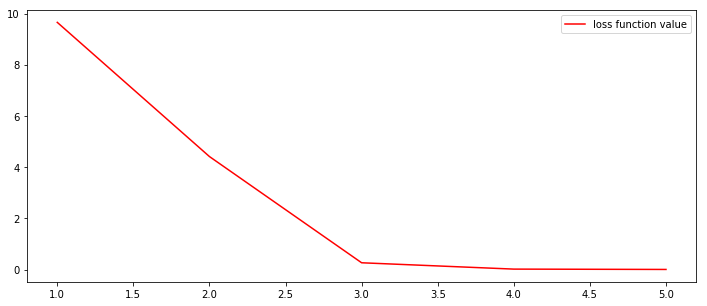

In [8]:
plt.figure(figsize=(12,5))
plt.plot(range(1, len(losses) + 1), losses, color='red', label='loss function value')
plt.gca().legend()
plt.show()

## Wygenerowane obrazki oszukujace siec

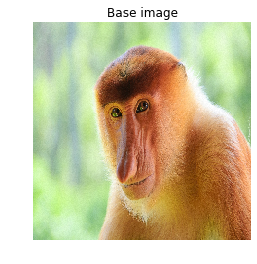

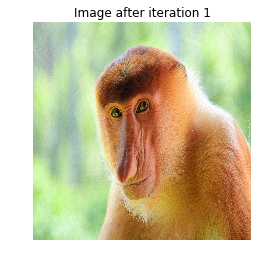

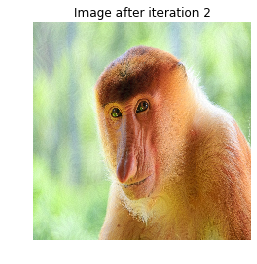

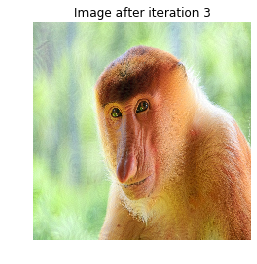

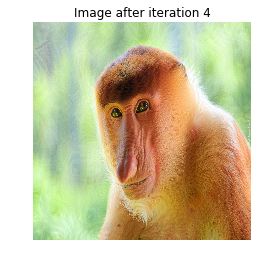

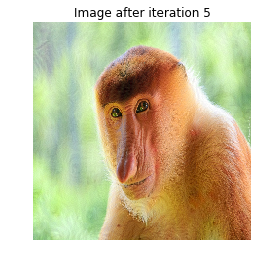

In [9]:
plt.imshow(load_img(changer.image_path, target_size=(224, 224)))
plt.title('Base image')
plt.axis('off')
plt.show()

for i, image in enumerate(images):
    plt.imshow(image)
    plt.title('Image after iteration ' + str(i+1))
    plt.axis('off')
    plt.show()